# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Text classification using LSTM and CNN.

In [2]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Variable

In [3]:
import os
import re
import nltk
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [4]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# Download dataset

In [5]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.1 MB/s eta 0:00:00


In [6]:
from datasets import load_dataset, DatasetDict

In [7]:
train_dataset = load_dataset("sst2", split = "train")
test_dataset = load_dataset("sst2", split = "validation")

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset sst2 downloaded and prepared to /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5. Subsequent calls will reuse this data.


In [8]:
texts, labels = [item["sentence"] for item in train_dataset], [item["label"] for item in train_dataset]

In [9]:
label_list = list(set([item for item in labels]))

In [10]:
label_list

[0, 1]

Concatenate and label data

In [11]:
from nltk.tokenize import word_tokenize
from collections import defaultdict
import numpy as np

In [12]:
def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

In [13]:
def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

Load pretrained vectors

In [14]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)

Tokenizing...



# Create dataloader

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [16]:
def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42, stratify = labels)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(
    train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

# Model

In [19]:
# Sample configuration:
filter_sizes = [3, 4, 5]
num_filters = [150, 150, 150]
hidden_units = 128
embed_dim = 200
hidden_dim = 100
dropout = .2
learning_rate = .25
epochs = 50
save_path = "/gdrive/MyDrive/PPNCKH/saved/SST2/cnn_lstm.pt"

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self,
                 vocab_size=None,
                 embed_dim=200,
                 hidden_units=128,
                 hidden_dim=100,
                 filter_sizes=[3, 4, 5],
                 num_filters=[150, 150, 150],
                 num_classes=None,
                 dropout=0.5):

        super(CNN_LSTM, self).__init__()
        # Embedding layer
        self.embed_dim = embed_dim
        self.embedding_cnn = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)

        self.embedding_lstm = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)

        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])

        self.lstm = nn.LSTM(
            input_size=self.embed_dim,
            hidden_size = hidden_units,
            num_layers=1,
            batch_first=True
        )

        # Fully-connected layer and Dropout
        self.fc1 = nn.Linear(np.sum(num_filters) + hidden_units, hidden_dim * 2)
        self.sm = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):

        # ============ CNN ================
        x_embed_cnn = self.embedding_cnn(input_ids).float()

        x_reshaped = x_embed_cnn.permute(0, 2, 1)

        # Conv then ReLU
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        cnn_output = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # ============ LSTM ================
        x_embed_lstm = self.embedding_lstm(input_ids).float()
        lstm_out, (h_out, _) = self.lstm(x_embed_lstm)

        # Concatenate LSTM output versus cnn output
        x_fc = torch.cat([h_out[-1].squeeze(dim = 1), cnn_output], dim = 1)

        first_fc = self.sm(self.fc1(x_fc))
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc2(self.dropout(first_fc))

        return logits

In [21]:
import torch.optim as optim

def initilize_model(vocab_size=None,
                    embed_dim=200,
                    hidden_units=128,
                    hidden_dim=100,
                    filter_sizes=[3, 4, 5],
                    num_filters=[150, 150, 150],
                    num_classes=None,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_LSTM(vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        hidden_units=hidden_units,
                        hidden_dim=hidden_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=num_classes,
                        dropout=dropout)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer


In [22]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, 
          optimizer, 
          train_dataloader, 
          val_dataloader=None, 
          epochs=10,
          save_path="checkpoint.pt"
          ):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                
                # Save best acc model.
                torch.save(model.state_dict(), save_path)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            # wandb.log({'val_accuracy': val_accuracy, 'val_loss': val_loss, 'train_loss' : avg_train_loss})
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

## Training

In [ ]:
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                        embed_dim=embed_dim,
                                        hidden_units=hidden_units,
                                        hidden_dim=hidden_dim,
                                        learning_rate=learning_rate,
                                        dropout=dropout,
                                        num_classes=len(label_list))
train(model = cnn_rand, 
      optimizer = optimizer, 
      train_dataloader = train_dataloader, 
      val_dataloader = val_dataloader, 
      epochs=epochs,
      save_path = save_path)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.671198   |  0.602429  |   68.07   |   16.35  
   2    |   0.476042   |  0.362358  |   84.29   |   10.83  
   3    |   0.275557   |  0.311424  |   87.07   |   10.96  
   4    |   0.179477   |  0.297201  |   88.55   |   10.80  
   5    |   0.128295   |  0.310452  |   89.06   |   10.86  
   6    |   0.093434   |  0.319448  |   89.36   |   13.33  
   7    |   0.069581   |  0.337970  |   89.38   |   11.04  
   8    |   0.051405   |  0.360562  |   89.80   |   11.01  
   9    |   0.042840   |  0.384888  |   89.81   |   11.21  
  10    |   0.033699   |  0.390686  |   89.81   |   10.94  
  11    |   0.026143   |  0.396040  |   90.09   |   11.01  
  12    |   0.020816   |  0.434240  |   89.97   |   11.09  
  13    |   0.017655   |  0.450569  |   90.03   |   10.94  
  14    |   0.013841   |  0.478004  |   89.74   |   11.04  
  15    |   0.012300

# Evaluation

Load state dict

In [23]:
best_checkpoint = CNN_LSTM(vocab_size=len(word2idx),
                            embed_dim=embed_dim,
                            hidden_units=hidden_units,
                            hidden_dim=hidden_dim,
                            # learning_rate=learning_rate,
                            dropout=dropout,
                            num_classes=len(label_list)).to("cpu")

In [24]:
best_checkpoint.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [25]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [26]:
count_parameters(best_checkpoint)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
|  embedding_cnn.weight |  2961200   |
| embedding_lstm.weight |  2961200   |
|  conv1d_list.0.weight |   90000    |
|   conv1d_list.0.bias  |    150     |
|  conv1d_list.1.weight |   120000   |
|   conv1d_list.1.bias  |    150     |
|  conv1d_list.2.weight |   150000   |
|   conv1d_list.2.bias  |    150     |
|   lstm.weight_ih_l0   |   102400   |
|   lstm.weight_hh_l0   |   65536    |
|    lstm.bias_ih_l0    |    512     |
|    lstm.bias_hh_l0    |    512     |
|       fc1.weight      |   115600   |
|        fc1.bias       |    200     |
|       fc2.weight      |    400     |
|        fc2.bias       |     2      |
+-----------------------+------------+
Total Trainable Params: 6568012


6568012

In [ ]:
def predict(text, model, max_len = 62):
    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = torch.argmax(F.softmax(logits, dim=1).squeeze(dim=0))

    return probs.item()

In [ ]:
def eval_testset(model):
    correct_label = []
    predicted_label = []
    
    for item in test_dataset:
        correct_label.append(item["label"])
        predicted_label.append(predict(item["sentence"], model))
    
    return predicted_label, correct_label

## Evaluate for cnn_rand

In [ ]:
y_pred_cnn_rand, y_true_cnn_rand = eval_testset(best_checkpoint)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
print(classification_report(y_true_cnn_rand, y_pred_cnn_rand))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75       428
           1       0.79      0.65      0.71       444

    accuracy                           0.73       872
   macro avg       0.74      0.74      0.73       872
weighted avg       0.74      0.73      0.73       872



In [ ]:
print(f"Accuracy: {accuracy_score(y_true_cnn_rand, y_pred_cnn_rand):.6f} \n \
Precision (macro): {precision_score(y_true_cnn_rand, y_pred_cnn_rand, average = 'macro'):.6f} \n \
Recall (macro): {recall_score(y_true_cnn_rand, y_pred_cnn_rand, average = 'macro'):.6f} \n \
F1 score (macro): {f1_score(y_true_cnn_rand, y_pred_cnn_rand, average = 'macro'):.6f}")


Accuracy: 0.733945 
 Precision (macro): 0.741244 
 Recall (macro): 0.735455 
 F1 score (macro): 0.732679


In [ ]:
print(confusion_matrix(y_true_cnn_rand, y_pred_cnn_rand))

[[350  78]
 [154 290]]


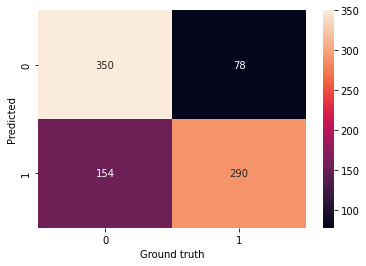

In [ ]:
sns.heatmap(confusion_matrix(y_true_cnn_rand, y_pred_cnn_rand), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [ ]:
for text, pred, truth in zip(test_dataset["sentence"][0:10], y_pred_cnn_rand[0:10], y_true_cnn_rand[0:10]):
    print(f"{text} -- {pred} -- {truth}")

it 's a charming and often affecting journey .  -- 1 -- 1
unflinchingly bleak and desperate  -- 0 -- 0
allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker .  -- 0 -- 1
the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales .  -- 1 -- 1
it 's slow -- very , very slow .  -- 0 -- 0
although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women .  -- 1 -- 1
a sometimes tedious film .  -- 0 -- 0
or doing last year 's taxes with your ex-wife .  -- 0 -- 0
you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance .  -- 1 -- 1
in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey .  -- 0 -- 0


Inference time measuring


In [ ]:
from time import perf_counter

In [ ]:
predicted_timelapse = []

for item in test_dataset:
    start_time = perf_counter()
    predict(item["sentence"], model = best_checkpoint)
    end_time = perf_counter()

    predicted_timelapse.append(end_time - start_time)

In [ ]:
timelapse_mean = np.mean(predicted_timelapse) * 1000
timelapse_std = np.std(predicted_timelapse) * 1000

In [ ]:
print(f"Mean: {timelapse_mean:.8f}, stdev: {timelapse_std:.8f} ms")

Mean: 6.60694274, stdev: 1.01033954 ms


In [ ]:
# wandb.finish()